In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from cv_proj_imports import *
from cv_proj_consts import *
from cv_proj_utils import *
from cv_proj_explore_map5_metric import *
from cv_proj_trainval_split import *
from cv_proj_arcface import *

/home/crazy_slime/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# transformations
# we get the filenames as input, and output:
# x as the image
# y as the whale name
tfms_x = [PILImage.create]
tfms_y = [filename_label, lambda o: train_labels_dict[o], Categorize()]
tfms = [tfms_x, tfms_y]

ds_img_tfms = [ToTensor(), Resize(224)]

dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dl_tfms.extend(aug_transforms(
    do_flip=False, # flipping makes it a different whale identity!
    flip_vert=False,
    max_rotate=30.,
    max_zoom=1.,
    max_lighting=0.4,
    max_warp=0.1,
    p_affine=0.75,
    p_lighting=0.75,
    pad_mode=PadMode.Border
))

In [4]:
trainval_splits = get_trainval_splits()
train_ds = DataSource(train_image_files, tfms, splits=trainval_splits)
train_db = train_ds.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=32, num_workers=0)

We will use 1078 whales for initial train/val


In [5]:
from fastai2.vision.learner import _resnet_split

opt_func = partial(Adam, lr=5e-3, wd=0.01)

arcface_loss = ArcFaceLoss().cuda() # this may not be needed just try it out
custom_head=Customhead(2048,1078)

model = create_cnn_model(
    arch=models.resnet34,
    nc = 1078,
    cut = -2,
    pretrained = True,
    custom_head=custom_head
)

learn = Learner(train_db, model, loss_func=arcface_loss, splitter = _resnet_split, opt_func=opt_func, metrics=[error_rate, mapk])

'Chosen LR: 0.000630957344480193'

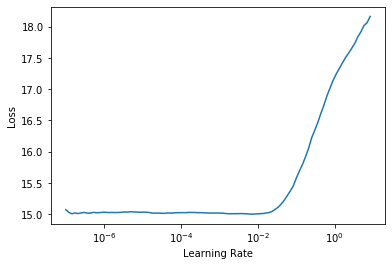

In [6]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [7]:
learn_cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=20),
    SaveModelCallback(monitor='valid_loss', fname='embedding_resnet34_20191027_arcface_best'),
    ReduceLROnPlateau(monitor='valid_loss', patience=5)
]

learn.fit(500, lr=chosen_lr, cbs=learn_cbs)

Epoch 40: reducing lr to 6.309573444801929e-05
Epoch 65: reducing lr to 6.30957344480193e-06
Epoch 70: reducing lr to 6.30957344480193e-07
Epoch 75: reducing lr to 6.30957344480193e-08
Epoch 81: reducing lr to 6.30957344480193e-09
Epoch 86: reducing lr to 6.30957344480193e-10
Epoch 91: reducing lr to 6.30957344480193e-11
No improvement since epoch 76: early stopping


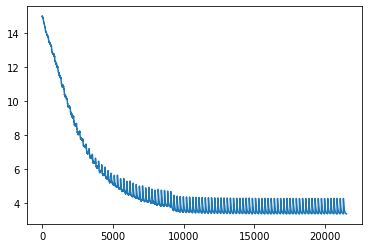

In [8]:
learn.recorder.plot_loss()

In [9]:
learn.unfreeze()

'Chosen LR: 0.0001'

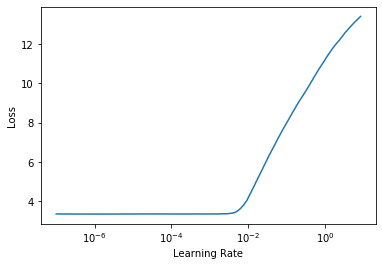

In [10]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [11]:
learn_cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=20),
    SaveModelCallback(monitor='valid_loss', fname='embedding_resnet34_20191027_arcface_unfreeze_best'),
    ReduceLROnPlateau(monitor='valid_loss', patience=5)
]

learn.fit(500, lr=chosen_lr, cbs=learn_cbs)

Epoch 8: reducing lr to 1e-05
Epoch 13: reducing lr to 1.0000000000000002e-06
Epoch 18: reducing lr to 1.0000000000000002e-07
No improvement since epoch 3: early stopping
